In [45]:
from torchvision import datasets, transforms
import torch
import numpy as np
import random 
import pickle
import corc
from sklearn.metrics import adjusted_rand_score
from collections import Counter
from scipy.cluster.hierarchy import dendrogram

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from corc.graph_metrics import neb
import sklearn
import studenttmixture
import corc.mixture

from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.colors as mcolors

custom_colors = ['steelblue', 'sandybrown', 
                 # 'red', 
                 'darkturquoise', 'tomato', 
                 'mediumslateblue', 
                 'firebrick', 'magenta', 'olive', 'limegreen', ]
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(custom_colors)

In [46]:
# the original MNIST-Nd embeddings were saved exactly like this
SEED = 1
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# default torchvision dataset 
# test_dataset = datasets.MNIST('./mnist', train=False, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(
    ..., # define mnist path here 
    train=False, transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False)

In [47]:
original_images = []
dataloader_labels = []
for i in test_loader:
    original_images.append(i[0].numpy())
    dataloader_labels.append(i[1].numpy())

In [48]:
original_images = np.concatenate(original_images).squeeze()
dataloader_labels = np.concatenate(dataloader_labels).squeeze()

In [49]:
original_images.shape, dataloader_labels.shape

((10000, 28, 28), (10000,))

## Now lets overcluster and look at what is returned

In [50]:
cache_path = ... #define cache path here

with open(f'{cache_path}stability/seeds_mnist32_35.pkl', 'rb') as f:
    seeds_mnist32_35 = pickle.load(f)

In [52]:
X, y, transformed_points = corc.utils.load_dataset(
    # dataset_name='varied', 
    # dataset_name='blobs',
    dataset_name='mnist32', 
    cache_path=cache_path
)


In [53]:
(dataloader_labels == y).all()

True

In [56]:
model = seeds_mnist32_35[6]

In [ ]:
original_linkage = []
new_clusters = {}
amount_of_points = dict(Counter(model.predict(X).tolist()))
counting = len(amount_of_points) 
prev = []
start_num = 0
for i in range(34, 0, -1):
    cur = model.get_merged_pairs(
            target_num_classes=i, only_mst_edges=True
        )
    new_edge = list(set(cur).difference(set(prev)))
    assert len(new_edge) == 1
    new_edge = new_edge[0]
    prev = cur
    new_amount = 0
    
    loc = new_edge[0]
    while loc in new_clusters:
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    from_ = loc    
    loc = new_edge[1]
    while loc in new_clusters:
        loc = new_clusters[loc]
    new_amount += amount_of_points[loc]
    new_clusters[loc] = counting
    to = loc
    

    original_linkage.append([from_, to, 
                    max(-model.adjacency_[new_edge[0], new_edge[1]], 0.01), 
                             # max(max(-model.adjacency_[new_edge[0], new_edge[1]], 0.01), model.adjacency_[new_edge[0], new_edge[1]]), 
                    new_amount])

    amount_of_points[counting] = new_amount
    counting += 1

In [219]:
# manually adjected positions for the labels for the improved readability
def plot_field(
    data_X,
    mixture_model,
    levels=20,
    paths=None,  # storage of all paths
    selection=None,  # selection which paths to plot
    save_path=None,
    axis=None,
    plot_points=True,  # whether data_X is plotted
    transformed_points=None,
    grid_resolution=128,
    plot_ids=True,
    markersize=6,
    point_colors=None,
    weight='normal',
    fontsize=6
):
    """Plots the TMM/GMM field and the optimized paths (if available).
    selection: selects which paths are included in the plot, by default, all paths are included.
      other typical options: MST through selection=zip(mst.row,mst.col) and individuals via e.g. [(0,1), (3,4)]

    """
    locations = corc.utils.mixture_center_locations(mixture_model)
    n_components = len(locations)

    # Compute TSNE if necessary
    if data_X.shape[-1] > 2:
        if transformed_points is None:
            transformed_points = corc.utils.get_TSNE_embedding(data_X)
        locations = corc.utils.snap_points_to_TSNE(
            locations, data_X, transformed_points
        )
    else:
        transformed_points = data_X

    if axis is None:
        figure, axis = plt.subplots(1, 1)

    

    # plot the raw data
    if plot_points:
        axis.scatter(
            transformed_points[:, 0], transformed_points[:, 1], s=markersize/2, label="raw data", c=point_colors
        )

    # plot cluster centers and IDs
    axis.scatter(
        locations[:, 0],
        locations[:, 1],
        color="black",
        # marker="X",
        label="mixture centers",
        s=markersize,
    )
    if plot_ids:
        # for i, location in enumerate(locations):
        #     y_min, y_max = axis.get_ylim()
        #     scale = y_max - y_min
        #     axis.annotate(f"{i}", xy=location - 0.05 * scale, color="black")

        for i, location in enumerate(locations):
            y_min, y_max = axis.get_ylim()
            scale = y_max - y_min
            if i in [31, 27]:
                axis.text(location[0]+0.2, location[1]-0.2, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [7, 9, 1]:
                axis.text(location[0], location[1]+0.4, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [16, 20, 6]:
                axis.text(location[0]-1.6, location[1]+2, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [25]:
                axis.text(location[0]-1.9, location[1]+1.2, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [17]:
                axis.text(location[0]-3.8, location[1]-0.8, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [15, 17]:
                axis.text(location[0]-3.8, location[1], f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [18]:
                axis.text(location[0]+0.5, location[1]-1, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [2, 3, 5, 29, 8]:
                axis.text(location[0]-1.5, location[1]-3.5, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [4]:
                axis.text(location[0]-2.5, location[1]-3, f"{i}", color="black", fontsize=fontsize, weight=weight)
            # elif i in [22]:
            #     axis.text(location[0]-2.5, location[1]+0.5, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [11]:
                axis.text(location[0], location[1]-2.5, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [30]:
                axis.text(location[0]-2.5, location[1]-3, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [23]:
                axis.text(location[0]+0.5, location[1]-0.7, f"{i}", color="black", fontsize=fontsize, weight=weight)
            elif i in [21, 24]:
                axis.text(location[0]-3, location[1]+0.5, f"{i}", color="black", fontsize=fontsize, weight=weight)
            else:
                axis.text(location[0]+0.5, location[1]+0.5, f"{i}", color="black", fontsize=fontsize, weight=weight)

    # plot paths between centers (by default: all)
    if paths is not None:
        if selection is None:
            selection = list(itertools.combinations(range(n_components), r=2))
        for i, j in selection:
            # path = paths[(i, j)]
            # axis.plot(path[:, 0], path[:, 1], lw=2, alpha=0.5, color="black")
            start = locations[i]
            end = locations[j]
            axis.plot(
                *zip(start, end),
                color="black",
                alpha=1,
            )


In [220]:
def create_color_map(labels_35, labels_10, min_saturation=0.4, max_saturation=0.8, min_brightness=0.6, max_brightness=1.0):
    """
    Creates a color map for 1000 points with 35 classes merged into 10 classes,
    ensuring that each major cluster has distinct colors and sub-clusters have easily distinguishable shades.

    Args:
        labels_35: List of labels for 1000 points with 35 classes.
        labels_10: List of labels for 1000 points with 10 merged classes.
        min_saturation: Minimum saturation level for colors.
        max_saturation: Maximum saturation level for colors.
        min_brightness: Minimum brightness level for colors.
        max_brightness: Maximum brightness level for colors.

    Returns:
        A list of RGB colors for the 1000 points.
    """
    # Define 10 distinct base colors for the 10 merged classes
    base_colors = plt.cm.tab10(np.linspace(0, 1, 10))[:, :3]  # Extract RGB values

    # Create a mapping of 35 classes to their corresponding merged classes
    class_to_merged_class = {label_35: label_10 for label_35, label_10 in zip(labels_35, labels_10)}

    # Create a mapping of each 35-class label to a unique shade
    color_map = {}
    for label_35 in np.unique(labels_35):
        merged_class = class_to_merged_class[label_35]
        base_color = base_colors[merged_class]  # Get the base color for the merged class

        # Convert base color to HSV
        hsv_color = mcolors.rgb_to_hsv(base_color)

        # Adjust saturation and brightness for sub-clusters
        saturation = np.random.uniform(min_saturation, max_saturation)
        brightness = np.random.uniform(min_brightness, max_brightness)
        hsv_color[1] = saturation
        hsv_color[2] = brightness

        # Convert back to RGB
        adjusted_color = mcolors.hsv_to_rgb(hsv_color)
        color_map[label_35] = adjusted_color

    # Assign colors to all 1000 points based on their 35-class label
    point_colors = [color_map[label] for label in labels_35]

    return point_colors

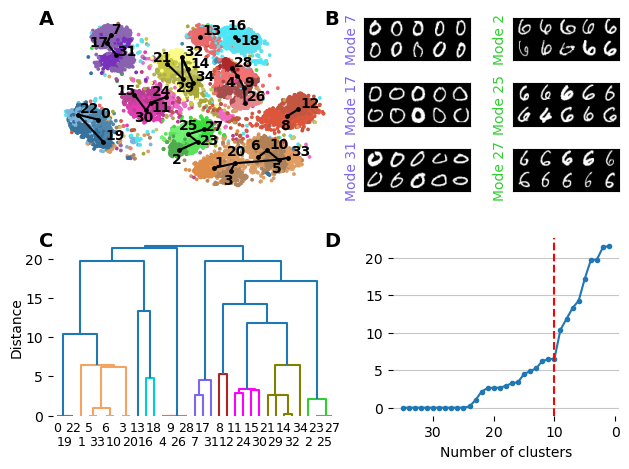

In [231]:
fontsize = 10
panel_letters_size = 14
fig, axes = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1.25, 1]}
                         # figsize=(3.5, 3), 
                         # gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1, 1]}
                        ) #figsize=[5.5, 2.8])
# Create a GridSpec for the parent grid
outer_gs = GridSpec(2, 2, figure=fig)
axes = axes.flatten()

# ---------------
ax = axes[0]

our_data = X
pairs = model.get_merged_pairs(
    target_num_classes=len(set(y)), only_mst_edges=True
)

labels_35 = np.asarray(model.predict(X).tolist())
labels_10 = np.asarray(model.predict_with_target(X, 10).tolist())
point_colors = create_color_map(labels_35, labels_10)
plot_field(
    data_X=our_data,
    mixture_model=model.mixture_model,
    paths=model.paths_,
    selection=pairs,
    axis=ax,
    plot_points=True,
    plot_ids=True,
    transformed_points=transformed_points,
    point_colors=point_colors,
    weight='bold',
    fontsize=fontsize
)
ax.tick_params(axis='both', labelsize=fontsize)
ax.axis('off')
ax.text(-0.05, 0.95, 'A', transform=ax.transAxes, 
            size=panel_letters_size, weight='bold')
# ---------------
ax = axes[1]
ax.axis('off')
ax.tick_params(axis='both', labelsize=fontsize)
ax.text(-0.3, 0.95, 'B', transform=ax.transAxes, 
            size=panel_letters_size, weight='bold')


# Hide the parent subplot (to use its space for the nested grid)
# ax.set_visible(False)


# Create a nested GridSpec within the space of the [1, 0] cell
nested_gs = GridSpecFromSubplotSpec(3, 2, subplot_spec=outer_gs[0, 1], wspace=0.4, hspace=0.4)

target_groups = [7, 2, 17, 25, 31, 27]
labels = np.asarray(model.predict(X).tolist())
# Loop to create nested subplots
counter = 0
cols = ['mediumslateblue', 'limegreen']
for i in range(3):
    for j in range(2):
        ax = fig.add_subplot(nested_gs[i, j])
        cur_label = target_groups[counter]
        indexs = np.where(labels == cur_label)[0]
        ax.imshow(
            np.vstack([np.hstack(original_images[indexs[:5]]), np.hstack(original_images[indexs[10:15]])]),
            # np.hstack(original_images[indexs[:5]]), 
            cmap='gray')
        # Set ylabel for the first column of subplots
        ax.set_ylabel(f"Mode {cur_label}", fontsize=fontsize, c=cols[j])
        ax.set_xticks([])
        ax.set_yticks([])
        counter += 1
# ---------------
ax = axes[3]
ax.tick_params(axis='both', labelsize=fontsize)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
threshold_dict, _ = model.get_thresholds_and_cluster_numbers()
xs = sorted(list(threshold_dict.keys()))[::-1]
ys  = [max(0, -threshold_dict[x]) for x in xs]
ax.plot(xs, ys, marker="o", markersize=3)
ax.set_xlabel("Number of clusters", fontsize=fontsize, labelpad=4)
# ax.set_ylabel("Distance", fontsize=fontsize, labelpad=1)
# plt.title("Clusters")
ax.grid(axis='y', alpha=0.7)
ax.invert_xaxis()
ax.axvline(x=10, color='r', linestyle='--') 

ax.text(-0.3, 0.95, 'D', transform=ax.transAxes, 
            size=panel_letters_size, weight='bold')
# ---------------
ax = axes[2]
# ax.set_xlabel("cluster ids", fontsize=fontsize, labelpad=1)
# TODO - make the labels more separated, maybe in 2 rows
ax.tick_params(axis='both', labelsize=fontsize)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.tick_params(axis='both', labelsize=fontsize)



_ = dendrogram(original_linkage, 
               color_threshold=10, 
               ax=ax, 
               # labels=offset_labels(list(range(35))),
               # leaf_rotation=90, 
               leaf_font_size=fontsize,
              )

# plt.xticks(rotation=45, ha='right')

ticks = ax.get_xticks()
labels = [label.get_text() for label in ax.get_xticklabels()]
ax.text(-0.05, 0.95, 'C', transform=ax.transAxes, 
            size=panel_letters_size, weight='bold')
# # Stagger the labels by modifying their vertical alignment
# for i, (tick, label) in enumerate(zip(ticks, labels)):
#     y_offset = -3 if i % 2 == 0 else -1  # Alternate y positions
#     ax.text(
#         tick, y_offset, label, rotation=60, ha='center', va='center', fontsize=fontsize-2
#     )
#     # ax.plot([tick, tick], [0, -3], 'k--', lw=0.5, alpha=0.6)
#     ax.plot([tick, tick], [0, y_offset], transform=ax.transData, ls='--', lw=0.5, alpha=0.6, color='gray')


y_min, y_max = ax.get_ylim()

# Stagger the labels and add dashed lines
for i, (tick, label) in enumerate(zip(ticks, labels)):
    y_offset = y_min - (0.07 * (y_max - y_min)) if i % 2 == 0 else y_min - (0.15 * (y_max - y_min))
    ax.text(
        tick, y_offset, label, rotation=0, ha='center', va='center', fontsize=fontsize - 1
    )
    # Add a dashed line from the tick to the label
    ax.plot([tick, tick], [0, y_offset], transform=ax.transData, ls='--', lw=0.5, alpha=0.6, color='gray')

ax.set_ylabel("Distance", fontsize=fontsize, labelpad=1)
ax.set_xticks([])  
# ax.set_xlabel("Number of clusters", fontsize=fontsize, labelpad=25)
# ax.tick_params(axis='x', which='both', bottom=True, length=4)
# ax.set_xlabel("cluster ids", fontsize=fontsize, labelpad=1)
plt.tight_layout()
plt.subplots_adjust(
    wspace=0.22, 
    hspace=0.25
)
# ---------------

# plt.savefig(
#     # f"{pre}figures/claude_neb_join_strategies_{dataset_name}_seed_{seed}_n_components_{n_components}.pdf",
#     'draft_interp.pdf', bbox_inches='tight', pad_inches=0)

plt.savefig(
    # f"{pre}figures/claude_neb_join_strategies_{dataset_name}_seed_{seed}_n_components_{n_components}.pdf",
    'draft_interp.png', bbox_inches='tight', pad_inches=0, dpi=600)